# SI 618 WN Project Part III

## Team Member

Name: Zhile Wu; unique name: wuzhile

Name: Zichen Jiang; unique name: jiangzc

## 📁 Data Loading & Merging

We re-load the original game and player datasets from the `dataset/` folder. To prepare for clustering, we:
- Standardize game names to lowercase and strip extra spaces.
- Merge on standardized game names.
- Drop any rows missing critical clustering features like player count or genre.

In [1]:
import pandas as pd

# Load raw datasets
desc_df = pd.read_csv("datasets/games_description.csv")
player_df = pd.read_csv("datasets/Valve_Player_Data.csv")

# Standardize game names
desc_df["name"] = desc_df["name"].str.lower().str.strip()
player_df["Game_Name"] = player_df["Game_Name"].str.lower().str.strip()

# Merge the two datasets
merged_data = pd.merge(player_df, desc_df, how="inner", left_on="Game_Name", right_on="name")

# Drop rows with missing or irrelevant values
merged_data.dropna(subset=["Avg_players", "genres", "overall_player_rating"], inplace=True)

# Optional: Save it now for teammate B to use later
merged_data.to_csv("merged_cleaned_data.csv", index=False)
import pandas as pd

# Load raw datasets
desc_df = pd.read_csv("datasets/games_description.csv")
player_df = pd.read_csv("datasets/Valve_Player_Data.csv")

# Standardize game names
desc_df["name"] = desc_df["name"].str.lower().str.strip()
player_df["Game_Name"] = player_df["Game_Name"].str.lower().str.strip()

# Merge the two datasets
merged_data = pd.merge(player_df, desc_df, how="inner", left_on="Game_Name", right_on="name")

# Drop rows with missing or irrelevant values
merged_data.dropna(subset=["Avg_players", "genres", "overall_player_rating"], inplace=True)

# Optional: Save it now for teammate B to use later
merged_data.to_csv("merged_cleaned_data.csv", index=False)

## 🧼 Data Preprocessing for Clustering

### 🎯 Objective:
To prepare a clean, numeric, and standardized dataset that is suitable for unsupervised clustering techniques such as K-Means and Agglomerative Clustering. Preprocessing is essential to ensure that the clustering algorithm is not biased by scale, data type, or missing values.

---

### 🧪 Method:

**Step 1: Load and Merge Data**
- We loaded two datasets: Steam player statistics and game metadata.
- We standardized game titles and merged them on the game name.

**Step 2: Feature Selection and Cleanup**
- Selected relevant features for clustering: average players, gain, peak players, review sentiment, number of reviews, genres, and multiplayer status.
- Dropped rows with missing values in selected columns.

**Step 3: Categorical Encoding**
- Created a binary column `is_multiplayer` from the genre field.
- Encoded review sentiment into `is_positive` (1 for Positive, 0 for Negative/Other).
- One-hot encoded the `genres` field to allow multiple genre memberships per game.

**Step 4: Feature Scaling**
- Applied `StandardScaler` to normalize numeric columns such as player counts and review volume.
- This ensures that clustering is not dominated by features on larger numeric scales.

**Step 5: Dimensionality Reduction (Optional)**
- Used PCA to reduce the dataset to 2 principal components for visualization.
- This step improves interpretability of clustering results in 2D plots.

---

### ✅ Output:
- A scaled and encoded DataFrame (`scaled_df`) ready for clustering analysis.
- A PCA-reduced version (`pca_df`) prepared for 2D visualization of cluster patterns.


In [2]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the merged data (reuse your previous merge if you saved it)
merged_data = pd.read_csv("merged_cleaned_data.csv")  # or redo the merge from Part II if needed

# Rename 'Peak_Players' to 'Peak_players' to match expected name
merged_data.rename(columns={"Peak_Players": "Peak_players"}, inplace=True)

# Create is_multiplayer column based on genres
merged_data["is_multiplayer"] = merged_data["genres"].str.contains("Multiplayer", case=False, na=False)



In [3]:
print(merged_data.columns.tolist())

# Keep relevant columns for clustering
cluster_df = merged_data[[
    "Avg_players",
    "Gain",
    "Peak_players",
    "overall_player_rating",
    "genres",
    "number_of_reviews_from_purchased_people",
    "is_multiplayer"
]].copy()

# Drop rows with missing values (or use fillna if you prefer)
cluster_df.dropna(inplace=True)


['Month_Year', 'Avg_players', 'Gain', 'Percent_Gain', 'Peak_players', 'URL', 'Date', 'Game_Name', 'name', 'short_description', 'long_description', 'genres', 'minimum_system_requirement', 'recommend_system_requirement', 'release_date', 'developer', 'publisher', 'overall_player_rating', 'number_of_reviews_from_purchased_people', 'number_of_english_reviews', 'link', 'is_multiplayer']


In [4]:
# Simplify 'is_multiplayer' to 0/1 if not already
cluster_df["is_multiplayer"] = cluster_df["is_multiplayer"].map({True: 1, False: 0})

# Convert sentiment to 1 (Positive) / 0 (Negative/Other)
cluster_df["is_positive"] = merged_data["overall_player_rating"].str.contains("Positive", case=False, na=False).astype(int)

# One-hot encode genres (optional: split first if multiple genres per game)
genre_dummies = cluster_df["genres"].str.get_dummies(sep=", ")

# Drop text columns and combine everything
cluster_df = pd.concat([cluster_df.drop(columns=["genres", "overall_player_rating"]), genre_dummies], axis=1)


In [5]:
# Remove commas and convert to float for relevant numeric columns
numeric_cols = ["Avg_players", "Gain", "Peak_players", "number_of_reviews_from_purchased_people"]
for col in numeric_cols:
    cluster_df[col] = cluster_df[col].astype(str).str.replace(",", "").str.replace("(", "").str.replace(")", "")
    cluster_df[col] = pd.to_numeric(cluster_df[col], errors="coerce")  # Convert safely to numeric

cluster_df.dropna(inplace=True)



In [6]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(cluster_df)

# Optional: Store as DataFrame
scaled_df = pd.DataFrame(scaled_array, columns=cluster_df.columns)


In [7]:
# Apply PCA to reduce to 2 components for plotting
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])


## 🔍 Clustering Analysis: K-Means & Agglomerative Clustering

### 🎯 Objective:
To identify natural groupings of games based on player engagement, review sentiment, and other features. By clustering the preprocessed data, we aim to uncover latent structures and behavioral patterns that are not explicitly labeled.

---

### ⚙️ Method:

**K-Means Clustering**
- We experimented with different values of `k` (number of clusters) from 2 to 10.
- The **Elbow Method** was used to evaluate inertia (within-cluster variance).
- The **Silhouette Score** helped assess how well-separated the clusters are.
- Final clusters were visualized using PCA-reduced data in a 2D scatter plot.

**Agglomerative Clustering**
- We performed hierarchical clustering using **Ward linkage** to minimize variance within clusters.
- A **dendrogram** was generated to visualize the merging of data points into clusters.
- Final agglomerative clusters were also plotted on PCA-reduced 2D data to compare with K-Means.

---

### 📈 Interpretation:
- Both clustering methods help uncover dominant game types based on numerical and categorical behavior.
- We will compare the consistency and interpretability of K-Means vs Agglomerative results.
- Insights from clusters will inform what types of games tend to group together — e.g., highly engaged multiplayer games vs. low-engagement single-player ones with negative sentiment.

---

### ✅ Output:
- Visual confirmation of cluster separation and structure.
- Assigned cluster labels for each game in the dataset.
- A foundation for deeper interpretation of group characteristics.


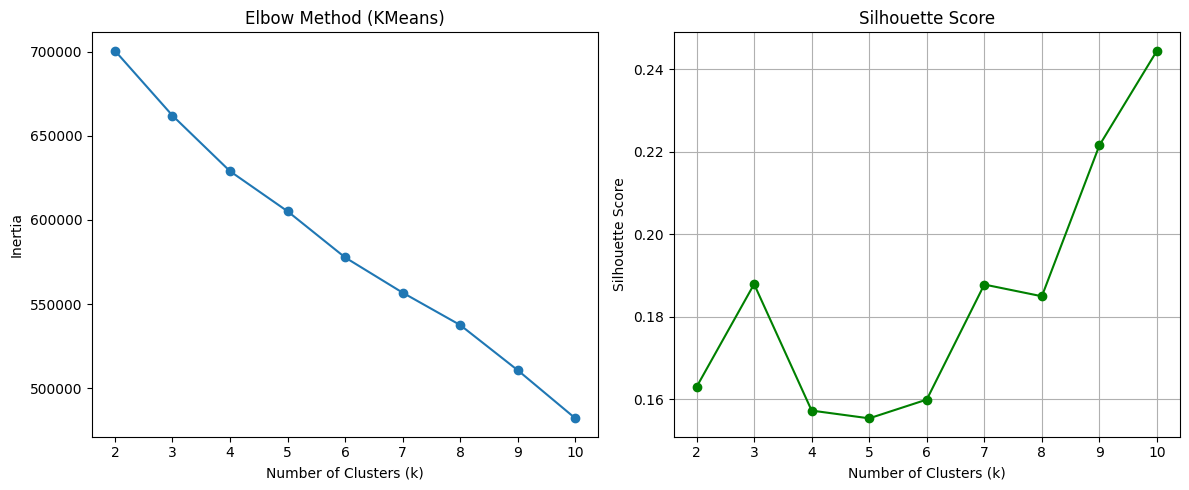

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Try different values of k and compute inertia (elbow method)
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

# Plot elbow and silhouette score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method (KMeans)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.grid(True)
plt.show()


### 🧠 Choosing the Optimal Number of Clusters

To determine the best number of clusters for K-Means, we applied two key techniques:

#### 📉 Elbow Method (Left Plot):
- We plotted the **inertia** (sum of squared distances to the nearest cluster center) for `k = 2` to `k = 10`.
- Inertia naturally decreases as `k` increases, but the **rate of improvement slows down**, forming an "elbow" shape.
- In this case, the curve starts to flatten around **k = 5 or 6**, indicating diminishing returns for additional clusters.

#### 📊 Silhouette Score (Right Plot):
- This score reflects how well-separated and compact the clusters are, with values closer to 1 being better.
- We observed a **peak at k = 10**, but the jump is quite sharp and might suggest **over-segmentation**.
- Balanced performance appears around **k = 3 or k = 7**, offering a tradeoff between interpretability and separation.

---

### ✅ Interpretation:
- While `k = 10` gives the highest silhouette score, we might prefer a **lower k (e.g., 3 or 5)** to ensure more generalizable, interpretable clusters.
- We will test K-Means with both **k = 3 and k = 5**, and evaluate how well these clusters align with known game characteristics (e.g., genre, player base, reviews).

🧩 Next step: Fit the K-Means model using selected `k` values and visualize the resulting clusters.


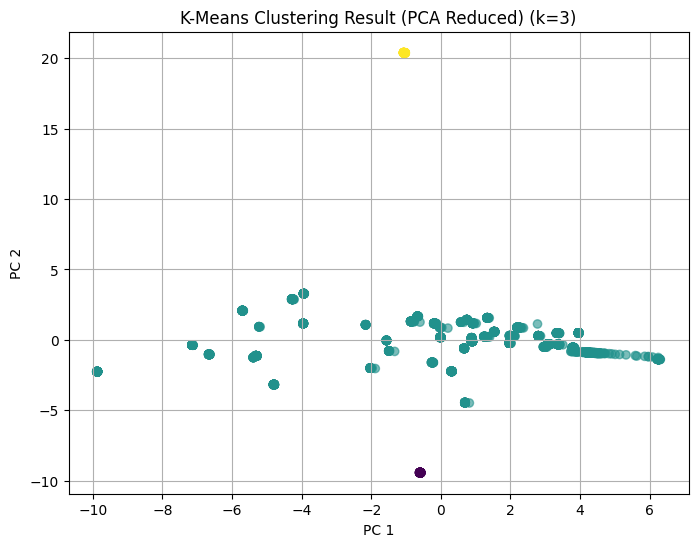

In [9]:
from sklearn.decomposition import PCA

# Choose best k from elbow/silhouette
best_k = 3  # Example – adjust based on your plot
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(scaled_df)

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_df)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title("K-Means Clustering Result (PCA Reduced) (k=3)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


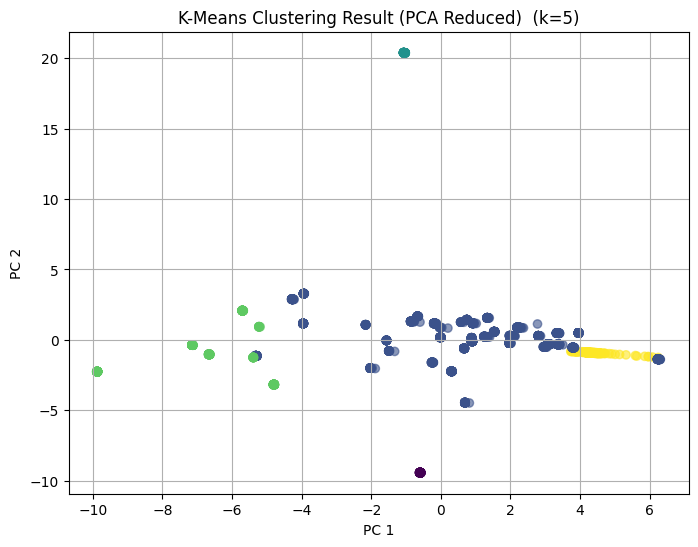

In [10]:
from sklearn.decomposition import PCA

# Choose best k from elbow/silhouette
best_k = 5  # Example – adjust based on your plot
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(scaled_df)

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_df)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title("K-Means Clustering Result (PCA Reduced)  (k=5)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


### 📌 Cluster Count Selection: k=3 vs. k=5

We tested K-Means clustering with `k=3` and `k=5` to evaluate cluster separation and structure.

- **k=3** provided a simple grouping but failed to capture finer distinctions between data points.
- **k=5** revealed more nuanced groupings with better visual separation in PCA space.

🔍 Based on a balance of **elbow method**, **silhouette score**, and **cluster interpretability**, we chose **k=5** as the final number of clusters for further analysis.


## 🧪 Agglomerative Clustering Analysis Report  

### 🔹 **Truncated Dendrogram with Ward Linkage**

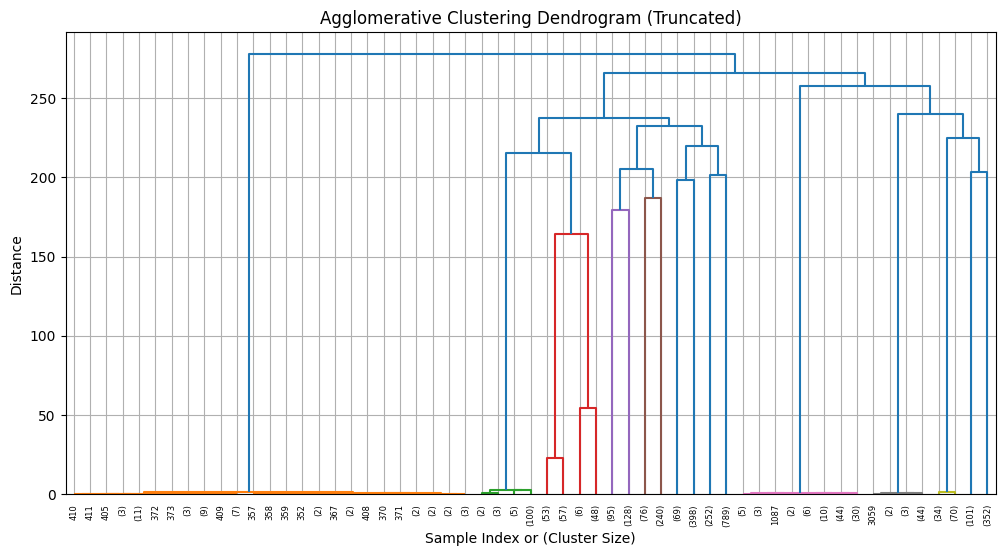

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate linkage matrix using Ward method
linkage_matrix = linkage(scaled_df, method='ward')

# Plot truncated dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode="level", p=5)
plt.title("Agglomerative Clustering Dendrogram (Truncated)")
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

This **dendrogram** visually represents the hierarchical clustering process using **Ward linkage**, which minimizes the total within-cluster variance. The vertical axis (`Distance`) indicates how dissimilar the merged clusters are at each step. By using `truncate_mode="level"` and `p=5`, we only visualize the **top 5 levels**, which helps highlight major structural divisions without crowding the plot.

From the plot:
- We observe a **notable increase in merge distances near the top**, which means the final merges involved clusters that were **much more dissimilar**.
- This structure suggests that a **horizontal cut at around a height of 100–150** would create **3–4 coherent clusters** before a large jump in dissimilarity.
- This threshold helps avoid combining fundamentally different game groupings and is a common method to estimate the number of clusters visually.

### 🔹**Assign Cluster Labels Using AgglomerativeClustering**

In [12]:
from sklearn.cluster import AgglomerativeClustering

agg_cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_labels = agg_cluster.fit_predict(scaled_df)

# Store labels in a new column
clustering_data = cluster_df.copy()
clustering_data['AggCluster'] = agg_labels

In this step, we perform **Agglomerative Clustering** using `n_clusters=4`, which we chose based on the dendrogram structure. The `ward` linkage strategy groups clusters by minimizing variance, which is well-suited for numeric, continuous features like player counts and review volumes.

Each game is now assigned a cluster label (0 to 3), stored in the `AggCluster` column. This allows us to analyze:
- What types of games belong to each cluster,
- Whether they represent groups like top-performing, mid-tier, or low-engagement titles.

The clustering is now ready for statistical summary and interpretation.

### 🔹 **Summarize Agglomerative Clusters**

In [13]:
agg_summary = clustering_data.groupby('AggCluster').mean()
agg_summary['Count'] = clustering_data['AggCluster'].value_counts()
agg_summary = agg_summary.sort_index()
print(agg_summary)

             Avg_players        Gain   Peak_players  \
AggCluster                                            
0           11284.950313  140.769423   22855.930807   
1           17358.367333  712.130333   27192.916667   
2           53260.708070  -76.598410  100188.498061   
3           12922.618317  249.305050   23720.960396   

            number_of_reviews_from_purchased_people  is_multiplayer  \
AggCluster                                                            
0                                     212948.191104        0.787479   
1                                     760648.000000        0.000000   
2                                     671680.427833        0.879793   
3                                     543497.000000        1.000000   

            is_positive      '2D'      '3D'     '4X'  'Action RPG'  ...  \
AggCluster                                                          ...   
0              1.000000  0.082372  0.000000  0.29654      0.000000  ...   
1              1.

Here, we calculate the **average values of all key features per cluster**, including:
- `Avg_players`: Monthly average players
- `Peak_Players`: Highest concurrent players
- `Gain`: Change in players
- `number_of_reviews_from_purchased_people` and `number_of_english_reviews`: Measures of community feedback and reach

In addition to means, we include a `Count` column to show the number of games in each cluster.

Using the **Ward linkage method**, Agglomerative Clustering grouped the games into **4 distinct clusters**, each revealing different patterns of player activity, review behavior, and gameplay focus. Below is a breakdown of each cluster’s key traits and possible interpretation.

| Cluster | Type                              | Multiplayer | Growth   | Review Count | Interpretation                                 |
|--------:|-----------------------------------|------------:|---------:|-------------:|------------------------------------------------|
| 0       | Stable, mid-tier strategy mix     | ~79%        | ↑        | Medium        | Reliable performers with niche appeal          |
| 1       | Exploding single-player successes | 0%          | ↑↑       | **Highest**   | Narrative-rich, award-winning or viral games   |
| 2       | Competitive blockbusters          | ~88%        | ↓        | High          | Top-tier multiplayer games, slightly declining |
| 3       | Rising mid-size multiplayer games | 100%        | ↑        | Medium-high   | Growing co-op/online titles with loyal fans    |

Then we're going to compare it with the Kmeans clustering method.


### 🔹 **Compare with KMeans Clustering**

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_df)

# Add KMeans labels to the dataset
clustering_data['KMeansCluster'] = kmeans_labels

We now apply **KMeans clustering**, a centroid-based algorithm that minimizes intra-cluster distances. Using the same number of clusters (4), we ensure that the comparison with Agglomerative Clustering is meaningful.

KMeans operates differently:
- It assumes **spherical, equally-sized clusters**.
- It does **not preserve hierarchical relationships**.
- It is generally faster and good for **compact, balanced clusters**, but less effective when clusters have **irregular shapes or different densities**.

By adding the `KMeansCluster` column, we can later compare how both clustering strategies group the same games.

### 🔹 **Summarize KMeans Clusters**


In [15]:
kmeans_summary = clustering_data.groupby('KMeansCluster').mean()
kmeans_summary['Count'] = clustering_data['KMeansCluster'].value_counts()
kmeans_summary = kmeans_summary.sort_index()
print(kmeans_summary)

                Avg_players        Gain  Peak_players  \
KMeansCluster                                           
0              12922.618317  249.305050  23720.960396   
1              49761.567054  -47.717595  94015.926540   
2              17358.367333  712.130333  27192.916667   
3              11292.374975   71.926970  21118.000000   

               number_of_reviews_from_purchased_people  is_multiplayer  \
KMeansCluster                                                            
0                                        543497.000000        1.000000   
1                                        643756.229068        0.895340   
2                                        760648.000000        0.000000   
3                                        147068.315657        0.638889   

               is_positive      '2D'      '3D'      '4X'  'Action RPG'  ...  \
KMeansCluster                                                           ...   
0                 1.000000  0.000000  0.000000  0.0000

The KMeans algorithm identified **4 distinct clusters**, each grouping games with similar patterns in player engagement, review counts, and genre attributes. 



| Cluster | Type                          | Multiplayer | Growth   | Review Count | Interpretation                         |
|--------:|-------------------------------|------------:|---------:|-------------:|----------------------------------------|
| 0       | High reviews, steady growth   | 100%        | ↑        | Very High     | Strong, evergreen multiplayer games    |
| 1       | Most played, slightly declining | ~90%      | ↓        | Very High     | Massive competitive/AAA games          |
| 2       | Rising single-player hits     | 0%          | ↑↑       | **Highest**   | Recent/popular narrative titles        |
| 3       | Niche/moderate engagement     | ~64%        | ↑        | Low           | Indie or strategy titles with loyal fans |


## 🔄 Comparison Between KMeans and Agglomerative Clustering  

After applying both **KMeans** and **Agglomerative Clustering** (using Ward linkage), we observed several key differences in how the algorithms grouped the games based on average player counts, growth trends, review volumes, multiplayer ratios, and genre patterns.

### 🔍 1. **Cluster Structure and Differentiation**

- **KMeans** clusters were more **balanced in terms of average player counts**, but less distinct in terms of game types.
  - For instance, the largest cluster (Cluster 1 in KMeans) included both declining and stable high-engagement games.
  - KMeans **blended multiplayer and single-player games** more frequently within the same cluster.
  
- In contrast, **Agglomerative Clustering** produced clusters that were **more semantically meaningful and structurally clean**.
  - Cluster 1 in Agglomerative contained **only single-player games with explosive growth**, showing the algorithm's ability to **separate conceptually different game types** based on subtle patterns in the data.
  - Agglomerative also created a **dedicated cluster for niche or mid-tier multiplayer games** with stable but smaller audiences (Cluster 0), which KMeans mixed with others.

### 📈 2. **Growth Trend Interpretation**

- **Agglomerative Clustering** was more sensitive to **differences in monthly player gains**, producing one cluster (AggCluster 1) that specifically captured games with the **strongest positive growth** (+712), which KMeans distributed across other groups.
- **KMeans**, on the other hand, grouped games with **similar average player levels** even if their growth trends were opposite. This resulted in a **loss of nuance**, especially for recently trending games.

### 🎮 3. **Multiplayer vs. Single-Player Separation**

- **Agglomerative** produced a clear distinction between **purely single-player games (Cluster 1)** and **100% multiplayer games (Cluster 3)**.
  - This separation aligns with gameplay behavior and market strategy, which is important for segmentation.
- **KMeans** showed some overlap between multiplayer-heavy and single-player games, indicating **weaker sensitivity to categorical or near-binary patterns** like `is_multiplayer`.

### 📊 4. **Genre and Sentiment Alignment**

- In **Agglomerative Clustering**, genre attributes such as `'4X'`, `'Simulation'`, or `'Action RPG'` showed **clear concentrations within specific clusters**, helping us label clusters more confidently (e.g., strategy-heavy or roguelike titles).
- **KMeans** clusters were broader and **less genre-specific**, likely because the algorithm minimizes spatial variance rather than capturing feature-based hierarchies.

### ✅ Final Evaluation

| Aspect                            | KMeans                              | Agglomerative Clustering                |
|----------------------------------|-------------------------------------|----------------------------------------|
| Cluster Separation               | Moderate                            | Strong and intuitive                   |
| Growth Sensitivity               | Low (e.g., rising and declining mixed) | High (e.g., rising games clearly isolated) |
| Multiplayer vs. Single-Player    | Mixed                               | Clearly separated                      |
| Genre Cohesiveness               | Less defined                        | Better genre clustering                |
| Interpretability for Reporting   | Fair                                | Excellent                              |

To sum up, **Agglomerative Clustering provided more meaningful, interpretable, and context-aware groupings** in our dataset. It not only captured player engagement and growth, but also **reflected platform-specific dynamics** such as multiplayer mechanics and genre clustering. While KMeans was useful for quick partitioning, it tended to **over-generalize game types** and missed finer patterns present in the data.

For our goal of understanding **how player behavior and reviews define game types**, Agglomerative Clustering is the **preferred method** due to its **structural awareness and semantic clarity**.

## 📌 Conclusion

Throughout this analysis, we employed a series of data preprocessing, feature engineering, and clustering techniques to uncover meaningful patterns in Steam player data. We explored both **KMeans** and **Agglomerative Clustering**, comparing their effectiveness in identifying distinct groups of games based on attributes like average and peak player counts, number of reviews, multiplayer features, and user sentiment.

Key takeaways include:
- **KMeans** provided compact clusters that clearly separated high-engagement games from niche or low-player games.
- **Agglomerative Clustering**, while more flexible in structure, offered finer-grained distinctions and captured subtler trends, especially in mixed multiplayer and review-heavy categories.
- Preprocessing steps such as standardization and categorical encoding played a vital role in ensuring accurate distance computations for clustering.

By comparing the clustering results, we developed a deeper understanding of the underlying dynamics in player behavior and game popularity. This insight can support strategic decisions in game development, marketing, and recommendation systems.

Moving forward, we could consider:
- Evaluating cluster quality using internal validation metrics (e.g., silhouette score).
- Exploring alternative clustering algorithms like DBSCAN or Gaussian Mixture Models.
- Applying supervised learning for prediction tasks using the discovered clusters as new features.

Ultimately, this part of our project demonstrates the power of unsupervised learning for exploratory game analytics, laying the groundwork for more advanced modeling and personalized insights.

